### taufit: model and extract the damping timescale in AGN light curves using celerite


Walkthrough demonstrating how to simulate and fit a damped random walk (DRW) light curve, using the DRW model kernel in [celerite](https://github.com/dfm/celerite):

$$ k(t_{nm}) = a \exp{(-c\ t_{nm})} $$

$$ = 2\sigma^2 \exp{(-t_{nm}/\tau_{\rm DRW})} $$

which corresponds to the structure function:

$$ SF^2 = 2\sigma^2(1-e^{|t_{nm}/\tau_{\rm DRW}|}) $$



where $\tau_{\rm DRW} = \frac{1}{c}$ and $\sigma=\sqrt{a/2}$.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from multiprocessing import Pool

Import package methods to simulate and fit DRW

In [63]:
import importlib, taufit
importlib.reload(taufit)
#
from taufit import simulate_drw
from taufit import fit_drw, fit_carma, fit_celerite

Generate simualted light curve with 6 seasons

In [11]:
#num_seasons = 6
#season_duration = 120 # days
#cadence = 7 # days
#x = [np.arange(365*i, 365*i + season_duration, cadence) for i in range(num_seasons)]
#x = np.array(x).flatten()
x = np.arange(0,2000,7)

Define function to simulate DRW light curves with similar amplitude fluctuations at a given timescale, typical mean magnitude, and error bars, with Gaussian white noise.

In [12]:
def simulate_and_fit_drw(x, log_tau_drw, sigma_hat=0.2, ymean=20, ysigma=0.02, plot=False, verbose=False):
    tau = 10**log_tau_drw
    # Change SFinf to display similar amplitude fluctuations at a given timescale
    SFinf = sigma_hat*np.sqrt(tau/250)
    # Simulate and fit DRW
    y = simulate_drw(x, ymean=ymean, tau=tau, SFinf=SFinf)
    yerr = np.full(np.shape(y), ysigma)
    # Add RMS fluctuations
    y += np.random.normal(0,ysigma,len(y))
    # Note the inputs to fit_drw must have astropy units
    gp, samples = fit_drw(x*u.day, y*u.mag, yerr*u.mag, plot=plot, verbose=verbose)
    log_tau_drw_recovered = np.log10(1/np.exp(np.median(samples[:,1])))
    return x, y, yerr, gp, samples

Simulate $\tau_{\rm{DRW}}=100$ days:

Initial log-likelihood: 405.0605292757778
Final log-likelihood: 421.367066632382
Running burn-in...
Running production...
plot tau


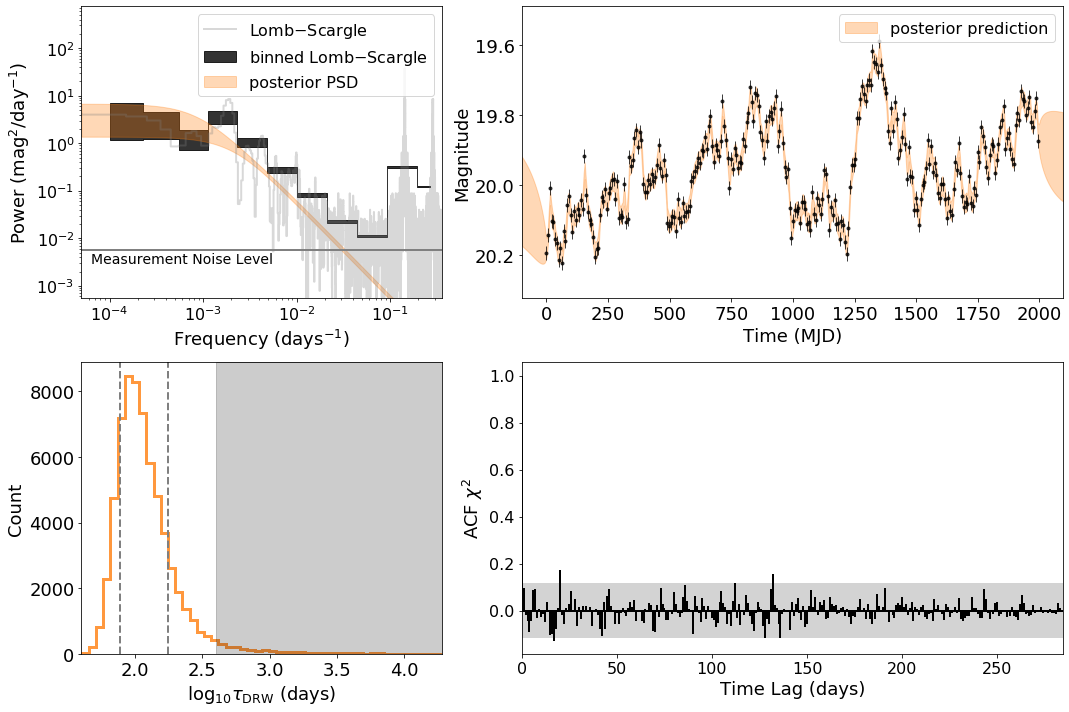

In [85]:
x, y, yerr, gp, samples = simulate_and_fit_drw(x, np.log10(100), plot=True, verbose=True)

Shown above: The power spectrum (top left), light curve and posterior model prediction $1\sigma$ error ellipses (top right), $\tau_{\rm{DRW}}$ posterior (bottom left) with 16th and 84th percentiles marked as dashed lines, and the autocorrelation function of the squared residuals (ACF $\chi^2$; bottom right). The ACF $\chi^2$ should located within the grey region (consistent with white noise).

**Important:** The grey shaded region in the $\tau_{\rm{DRW}}$ posterior plot (bottom left panel) corresponds to > 20% of the light curve baseline. If the distribution peaks in this region, the light curve is not long enough and the result is unreliable (see Kozlowski 2017).


Use corner to plot the posteriors with celerite's native variables or the equilivlant structure-function-convention variable:

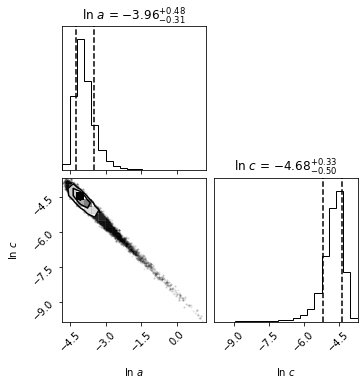

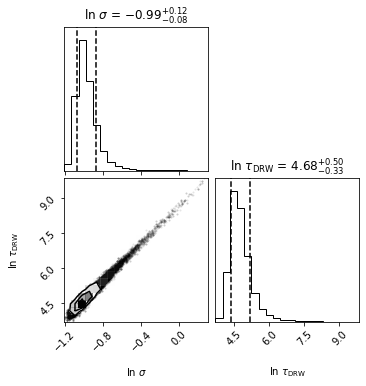

In [86]:
import corner
# Note these are natural logs
fig = corner.corner(samples, quantiles=[0.16,0.84], show_titles=True,
            labels=[r"$\ln\ a$", r"$\ln\ c$"]);
plt.show()
# Structure function variables
# sigma = sqrt(a/2), tau_DRW = 1/c
samples_sf = [np.log(np.sqrt(np.exp(samples[:,0]/2))), np.log(1/np.exp(samples[:,1]))]
samples_sf = np.array(samples_sf).T

fig = corner.corner(samples_sf, quantiles=[0.16,0.84], show_titles=True,
            labels=[r"$\ln\ \sigma$", r"$\ln\ \tau_{\rm{DRW}}$"]);

Celerite has been shown to be ${\sim}10 \times$ faster than codes such as carma\_pack, while having equivilent model PSDs to CARMA (Foreman-Mackey et al. 2017).

### Prediction

Posterior prediction at future times:

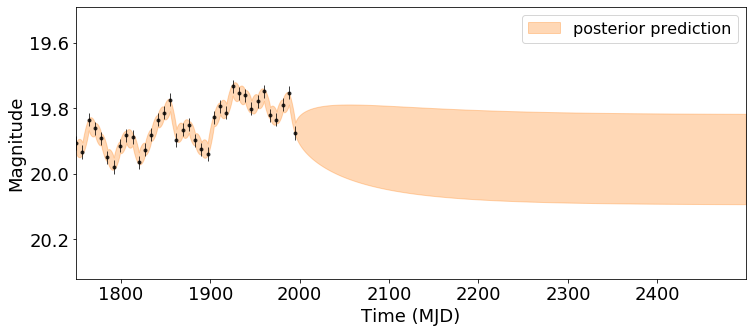

In [87]:
t = np.arange(1750, 2500, 1)

# Use just as you would with celerite
s = np.median(samples, axis=0)
gp.set_parameter_vector(s)
mu, var = gp.predict(y, t, return_var=True)
std = np.sqrt(var)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.errorbar(x, y, yerr=yerr, c='k', fmt='.', alpha=0.75, elinewidth=1)
ax.fill_between(t, mu+std, mu-std, color="#ff7f0e", alpha=0.3, label='posterior prediction')
ax.set_xlabel('Time (MJD)',fontsize=18)
ax.set_ylabel(r'Magnitude',fontsize=18)
ax.tick_params(labelsize=18)
ax.set_ylim(np.max(y) + .1, np.min(y) - .1)
ax.set_xlim(np.min(t), np.max(t))
ax.legend(fontsize=16, loc=1)

### Simulate complex kernel (CARMA model)

The kernel function for a general CARMA$(p, q)$ model is

$$ k(t_{nm}) = \sum^{p}_{j=1} A_j \exp(r_j t_{nm}).$$

*Note there is a typo in the published version of the paper: Eq. 60 is shown incorrectly as a sum to 2J.*

In celerite, this corresponds to a summation of `ComplexTerms`:

$$= \sum^{2J}_{j=1} \frac{1}{2}\left[(a_j+ib_j)e^{-(c_j+id_j) t_{nm}} +  (a_j-ib_j)e^{-(c_j-id_j) t_{nm}} \right]$$

where each CARMA term corresponds to a celerite term with $a_j=2\ \text{Re}(A_j)$, $b_j=2\ \text{Im}(A_j)$, $c_j=-\text{Re}(r_j)$, $d_j=-\text{Im}(r_j)$ (Foreman-Mackey et al. 2017; Footnote 17). Here, CARMA(p,q) the order is $p=2J$ and $q=p-1$. Note, there is no way to explicitly constrain q to be less than $p-1$ using the celerite solver, so we must adopt this general form.

Summing to $2J$, we can easily see that if $p=1, q=0$, we recover the DRW kernel (after noting that the imaginary terms $b_j=d_j=0$):

$$= \sum^{1}_{j=1} \frac{1}{2}\left[(a_j+ib_j)e^{-(c_j+id_j) t_{nm}} +  (a_j-ib_j)e^{-(c_j-id_j) t_{nm}} \right]$$

$$= \frac{1}{2}\left[ a_1e^{-c_1 t_{nm}} +  a_1e^{-c_1 t_{nm}} \right]$$

$$= a_1e^{-c_1 t_{nm}} $$

Initial log-likelihood: -362.783095537785
Running burn-in...
Running production...
plot tau


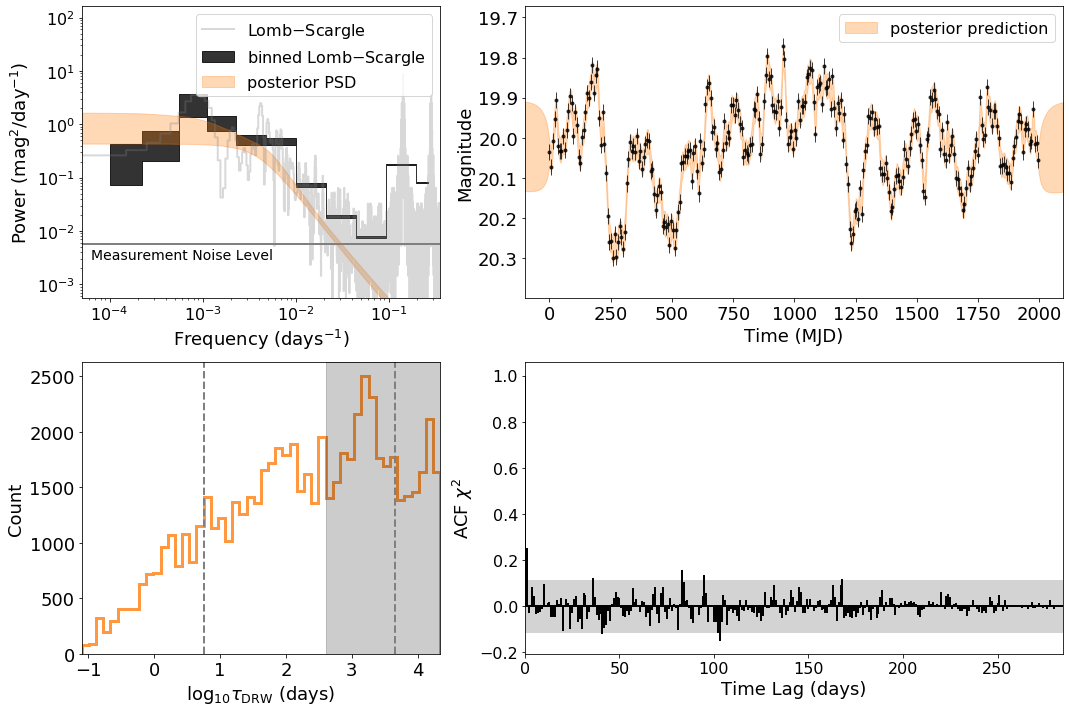

In [82]:
gp, samples = fit_carma(x*u.day, y*u.mag, yerr*u.mag, p=2, init=[-4,-6,-5,-4,-4,-6,-5,-4])

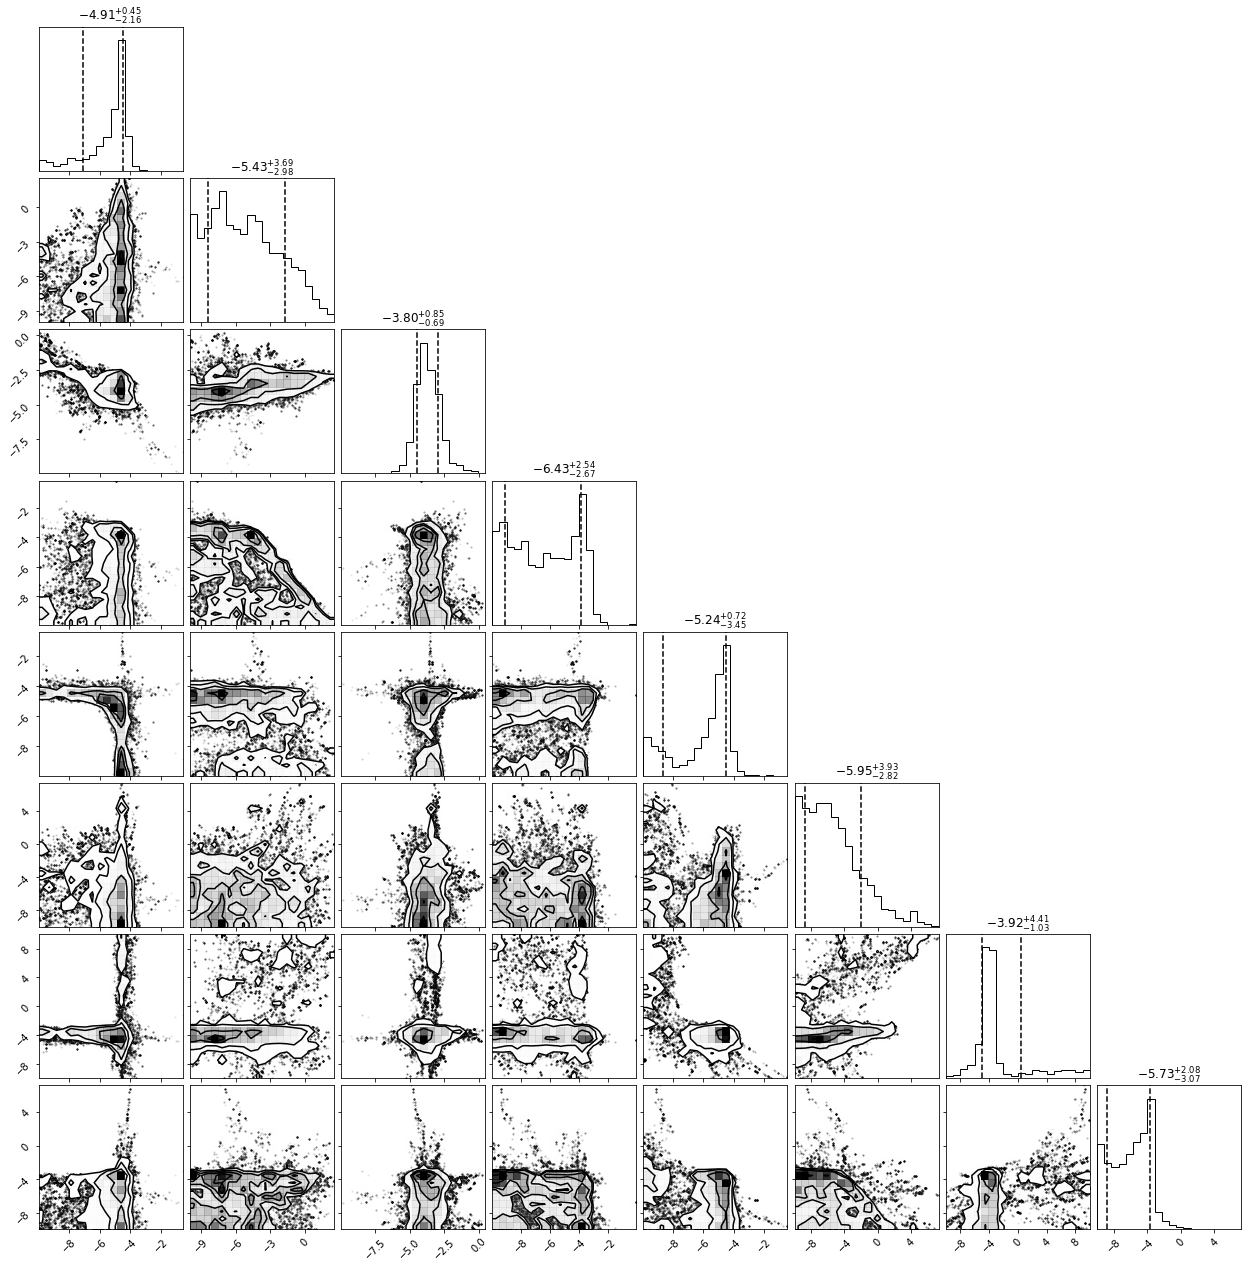

In [83]:
fig = corner.corner(samples, quantiles=[0.16,0.84], show_titles=True)

We recommend you set the `bounds` and `init` arguments yourself for better results. As you can, the parameters of higher order CARMA-like models quickly become difficult to physically interpret.

Equivilance to CARMA parameters

In [ ]:
### Coming soon!

### Assess bias in the fitting

Generate random DRW light curves with a range of input $\tau_{DRW}$, both seasonally-gapped and not, and see how well we can recover the input for each.

You may togggle whether to plot the output or not by changing the default arugments in `simulate_and_fit_drw` above.

In [69]:
# Modify the function above to create gaps in the light curve
def simulate_gapped(x, log_tau_drw, sigma_hat=0.2, ymean=20, ysigma=0.02, seed=None, plot=False, verbose=False):
    tau = 10**log_tau_drw
    # Change SFinf to display similar amplitude fluctuations at a given timescale
    SFinf = sigma_hat*np.sqrt(tau/250)
    # Simulate and fit DRW
    y = simulate_drw(x, xmean=ymean, tau=tau, SFinf=SFinf)
    yerr = np.full(np.shape(y), ysigma)
    # Add RMS fluctuations
    y += np.random.normal(0, ysigma, len(y))
    # Note the inputs to fit_drw must have astropy units
    gp, samples = fit_drw(x*u.day, y*u.mag, yerr*u.mag, plot=plot, verbose=verbose)
    log_tau_drw_recovered = np.log10(1/np.exp(np.median(samples[:,1])))
    # Gapped light curve
    x_gap = []; y_gap = []; yerr_gap = []
    days = 0
    for i in range(6):
        ind = (days<x) & (x<days+120)
        x_gap.append(x[ind])
        y_gap.append(y[ind])
        yerr_gap.append(yerr[ind])
        days += 365
    x_gap = np.concatenate(x_gap)
    y_gap = np.concatenate(y_gap)
    yerr_gap = np.concatenate(yerr_gap)
    # Note the inputs to fit_drw must have astropy units
    gp, samples = fit_drw(x_gap*u.day, y_gap*u.mag, yerr_gap*u.mag, plot=plot, verbose=verbose)
    log_tau_drw_recovered2 = np.log10(1/np.exp(np.median(samples[:,1])))
    # 
    return log_tau_drw, log_tau_drw_recovered, log_tau_drw_recovered2

In [70]:
# Generate input taus
x = np.arange(0,2000,7)
log_tau_drw_true = np.linspace(1, 5, 20*20)
# Use multiprocessing to pool each fitting to a simulated light curve
pool = Pool(20)
args = zip([x]*len(log_tau_drw_true), log_tau_drw_true)
taus = pool.starmap(simulate_gapped, args)
pool.close()
pool.join()
taus = np.array(taus)

/data/des90.a/data/cburke/conda/myenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/data/des90.a/data/cburke/conda/myenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/data/des90.a/data/cburke/conda/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/des90.a/data/cburke/conda/myenv/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/data/des90.a/data/cburke/conda/myenv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/des90.a/data/cburke/conda/myenv/lib/python3

### Plot the results

Plot input $\tau_{\rm{DRW}}$ vs. output $\tau_{\rm{DRW}}$. Note the confirmation of the bias reported by [Kozlowski (2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...597A.128K/abstract) when the input $\tau_{\rm{DRW}}$ approaches 20% of the light curve baseline. 

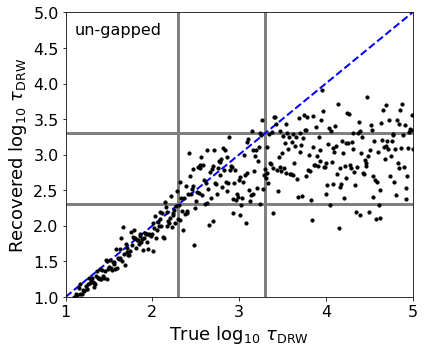

In [81]:
fig,ax = plt.subplots(1,1,figsize=(6,5), sharey=True)
ax.scatter(taus[:,0], taus[:,1], s=10, c='k')
ax.set_xlim(1,5)
ax.set_ylim(1,5)
ax.plot([1,5],[1,5], lw=2, color='b', zorder=-1, linestyle='dashed')
ax.tick_params('both',labelsize=16)
ax.set_xlabel(r'True $\log_{10}\ \tau_{\rm{DRW}}$',fontsize=18)
ax.set_ylabel(r'Recovered $\log_{10}\ \tau_{\rm{DRW}}$',fontsize=18)
#ax.legend(fontsize=16, loc=2)
# vertical lines at cadence (7 days) and baseline.
baseline = np.max(x) - np.min(x)
ax.vlines(np.log10(baseline),1,5, color='grey', lw=3, zorder=-1)
ax.hlines(np.log10(baseline),1,5, color='grey', lw=3, zorder=-1)
ax.vlines(np.log10(0.1*baseline),1,5, color='grey', lw=3, zorder=-1)
ax.hlines(np.log10(0.1*baseline),1,5, color='grey', lw=3, zorder=-1)
ax.text(1.1, 4.7, 'un-gapped', fontsize=16)
fig.tight_layout()

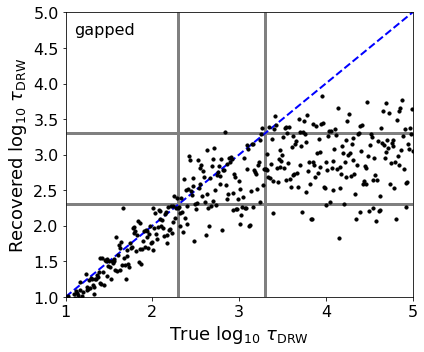

In [82]:
fig,ax = plt.subplots(1,1,figsize=(6,5), sharey=True)
ax.scatter(taus[:,0], taus[:,2], s=10, c='k')
ax.set_xlim(1,5)
ax.set_ylim(1,5)
ax.plot([1,5],[1,5], lw=2, color='b', zorder=-1, linestyle='dashed')
ax.tick_params('both',labelsize=16)
ax.set_xlabel(r'True $\log_{10}\ \tau_{\rm{DRW}}$',fontsize=18)
ax.set_ylabel(r'Recovered $\log_{10}\ \tau_{\rm{DRW}}$',fontsize=18)
#ax.legend(fontsize=16, loc=2)
# vertical lines at cadence (7 days) and baseline.
baseline = np.max(x) - np.min(x)
ax.vlines(np.log10(baseline),1,5, color='grey', lw=3, zorder=-1)
ax.hlines(np.log10(baseline),1,5, color='grey', lw=3, zorder=-1)
ax.vlines(np.log10(0.1*baseline),1,5, color='grey', lw=3, zorder=-1)
ax.hlines(np.log10(0.1*baseline),1,5, color='grey', lw=3, zorder=-1)
ax.text(1.1, 4.7, 'gapped', fontsize=16)

fig.tight_layout()